In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator 
import cv2

Using TensorFlow backend.


In [2]:
import json
def load_and_format(in_path):
    out_df = pd.read_json(in_path)  
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2'],np.add(c_row['band_1'],c_row['band_2'])/2], -1).reshape((75,75,3))],1)
    out_images = np.stack(out_images).squeeze()
    #out_images[:,:,:,0] = (out_images[:,:,:,0]-out_images[:,:,:,0].min())/(out_images[:,:,:,0].max()-out_images[:,:,:,0].min())
    #out_images[:,:,:,1] = (out_images[:,:,:,1]-out_images[:,:,:,1].min())/(out_images[:,:,:,1].max()-out_images[:,:,:,1].min())
    #out_images[:,:,:,2] = (out_images[:,:,:,2]-out_images[:,:,:,2].min())/(out_images[:,:,:,2].max()-out_images[:,:,:,2].min())
    return out_df, out_images
train_df, train_images = load_and_format('data/train.json')
print('training', train_df.shape, 'loaded', train_images.shape)

training (1604, 5) loaded (1604, 75, 75, 3)


In [3]:
def plot_list(arr):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(len(arr),1)
    for idx,ar in zip(range(len(arr)),arr):        
        ax = fig.add_subplot(gs1[idx])
        ax.plot(ar)
        
    gs1.tight_layout(fig)
    
################### Devesh DataAugmentation
def collage(img):    
    vis = np.concatenate((img,img), axis=0)
    vis2 = np.concatenate((vis,vis), axis=1)
    vis2 = vis2[25:150,25:150].copy()
    vis2 = cv2.resize(vis2, (75,75))
    return vis2

def add_salt_and_pepper(img, prob = 0.22):
    '''Adds "Salt & Pepper" noise to an image.
    gb: should be one-channel image with pixels in [0, 1] range
    prob: probability (threshold) that controls level of noise'''
    mean = 0
    sigma = 2
    im = np.zeros_like(img)
    cv2.randn(im,mean,sigma) # create the random distribution
    Fruit_Noise = cv2.add(img, im) # add the noise to the original image
    return Fruit_Noise


def makeMult(function,data, to_conc):
    new_data=np.empty_like(data)
    for i in range(0,len(data)):
        new_data[i,:,:,:]=function(data[i,:,:,:])
        
    return np.concatenate((to_conc, new_data), axis=0)

###########
    
import tensorflow as tf
def create_placeholders():
     ###place holders 
    global input_,input_post,label,keep_prob,is_train
    input_ = tf.placeholder(tf.float32, (None, 75, 75,3), name = 'features')
    input_post = tf.placeholder(tf.float32, (None,1), name = 'features2')
    label = tf.placeholder(tf.int32, (None, 2), name = 'labels')
    keep_prob = tf.placeholder(tf.float32)
    is_train = tf.placeholder(tf.bool, name='is_train')
tf.reset_default_graph()

In [4]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
state=2017
X_train, X_test, y_train, y_test,train_index,test_index = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),range(len(train_images)),
                                                    random_state = state,
                                                    test_size = 0.2
                                                   )
X_train_ang,X_test_ang  = train_test_split(train_df['inc_angle'].replace('na',0) / 50,random_state = state,test_size = 0.2)

half_len= int(len(X_train)/2)
print(half_len*2)
X_train_1 = makeMult(add_salt_and_pepper,X_train[:half_len],X_train)
y_train_1 = np.append(y_train,y_train[:half_len],axis=0)
X_train_ang_1 = X_train_ang.append(X_train_ang[:half_len])

X_train = makeMult(collage,X_train[half_len:],X_train_1)
y_train = np.append(y_train_1,y_train[half_len:],axis=0)
X_train_ang = X_train_ang_1.append(X_train_ang[half_len:])

print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

1282
Train (2566, 75, 75, 3) (2566, 2)
Validation (321, 75, 75, 3) (321, 2)


In [5]:
def lrelu(x, n, leak=0.2): 
    return tf.maximum(x, leak * x, name=n) 
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), name="weight")
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]), name ="bias")
def new_conv_layer(input, num_input_channels, filter_size, num_filters, num, is_train, use_pooling=True, use_bn=True
                  ):  
    
    conv = tf.layers.conv2d(input, num_filters, kernel_size=[filter_size, filter_size], strides=[1, 1], padding="SAME",
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name='conv'+str(num))
    
    if use_bn:
        conv = tf.contrib.layers.batch_norm(conv, is_training = is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope = 'bn'+str(num))
    
    if use_pooling:
        conv = tf.nn.max_pool(value=conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = lrelu(conv, n='act'+str(num))
    return layer

## Best Hyperparameters
filter_size = [3,3,3,3,3,3]          
num_filters = [3,8,16,36,36,64,64,128]     
drop_out = [1,.75,.75,.85,.75,.65,.55]  [1,.75,.85,.90,.85,.65,.55]  
pooling = [False,True,True,True,True,True,True]
     

In [6]:
num_channels = 3
## Hyperparameters
filter_size = [3,3,3,3,3,3]          
num_filters = [3,8,16,36,36,64,64,128]     
drop_out = [1,.75,.85,.90,.85,.65,.55]
pooling = [False,True,True,True,True,True,True]
bn = [True,True,True,True,True,False,True]
# Fully-connected layer.
fc_size = 128           # Number of neurons in fully-connected layer.

In [10]:
def CNN(conv,filter_size,num_filters,drop_out):
   
    ####33##########
    #batch_norm = tf.layers.batch_normalization(x, training=is_train)
    for n in range(len(filter_size)):
        conv = new_conv_layer(input=conv,
                           num_input_channels=num_filters[n],
                           filter_size=filter_size[n],
                           num_filters=num_filters[n+1],
                           num = n, is_train = is_train,
                           use_pooling=pooling[n],
                           use_bn= bn[n])
        conv = tf.nn.dropout(conv, drop_out[n] + (1-drop_out[n])*keep_prob)
        print(conv.shape)
    # Shortcut
    #flatten_layer = tf.contrib.layers.flatten(max_pool2)
    #fc = tf.contrib.layers.full_connected(flatten_layer, 256)
    
    # Long way of doing the fully_connected_layer
    _, height, width, depth = conv.shape
    
    tensor_size = int(height * width * depth +1) 
    flatten_layer = tf.reshape(conv, [-1, tensor_size-1])
    
    fc1_hidden_unit = int(tensor_size/1.5)
    print(tensor_size)
    print(fc1_hidden_unit)
    drop_fc1 = tf.nn.dropout(flatten_layer, 0.58 + keep_prob*0.42)
    drop_feat = tf.concat( [flatten_layer, input_post ], 1 )
    W_fc1 = new_weights([tensor_size, fc1_hidden_unit])
    b_fc1 = new_biases(fc1_hidden_unit)
    
    fc1 = lrelu(tf.add(tf.matmul(drop_feat, W_fc1), b_fc1),"fc1")
    drop_fc2 = tf.nn.dropout(fc1, 0.75 + 0.25*keep_prob)   #85
    
    n_class = 2
    W_fc2 = new_weights([fc1_hidden_unit, n_class])
    b_fc2 = new_biases(n_class)
                     
    logits = tf.add(tf.matmul(drop_fc2, W_fc2), b_fc2)
    
    return logits

In [11]:
tf.reset_default_graph()
create_placeholders()
logits = CNN(input_,filter_size,num_filters,drop_out)
logits_soft =tf.nn.softmax(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = label, logits = logits)
#error = tf.square(label-logits)/2
var_s = tf.trainable_variables()
loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in var_s if 'bias' not in v.name])*0.0001
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer().minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float32))

(?, 75, 75, 8)
(?, 38, 38, 16)
(?, 19, 19, 36)
(?, 10, 10, 36)
(?, 5, 5, 64)
(?, 3, 3, 64)
577
384


In [12]:
n_epoch = 80
batch_size =64

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
best_accuracy,min_loss = 0,10
acc_rec, loss_rec, loss_train = [], [], []

datagen = ImageDataGenerator(
                            width_shift_range=0,
                            height_shift_range=0,
                            zoom_range=0.22,
                            rotation_range = 0,
                            horizontal_flip=False,
                            vertical_flip=False,
                            featurewise_center = False,
                            featurewise_std_normalization= False
                            )
                            #fill_mode='nearest')
datagen.fit(X_train)

len_train = len(y_train)
def create_batches(n_batch, batch_size = batch_size, len_ = len_train):
    idx1 = n_batch*batch_size
    idx2 = n_batch*batch_size + batch_size
    arr = list(range(len_))
    if idx2>len_:
        idx2 = len_
        return arr[idx1:idx2],False
    return arr[idx1:idx2],True

y_datagen = [[y_train[x,0],y_train[x,1],X_train_ang.values[x]] for x in range(len(y_train))]

In [13]:
n_epoch = 80

batch_size =64
# early stopping
patience = 13
min_delta = 0.01
early_stop = False
for e in range(n_epoch):
    n_batch = 0
    status =True
    if early_stop == False:
        for x_batch, y_batch in datagen.flow(X_train, y_datagen, batch_size=batch_size):
            feed_dict = {input_: x_batch,label: y_batch[:,:2],
                                 input_post:y_batch[:,2:],keep_prob:0,is_train:True}
            _, loss_ = sess.run([optimizer, loss], feed_dict )
            train_acc = accuracy.eval(feed_dict = feed_dict,session=sess)

            if int(len_train/2) % (n_batch+1)  == 0:
                val_feed_dict = {input_: X_test,label: y_test, input_post:X_test_ang.values.reshape([-1,1]),
                                 keep_prob:1,is_train:True }
                val_loss = sess.run(loss, feed_dict = val_feed_dict)
                val_acc = accuracy.eval(feed_dict = val_feed_dict,session=sess)
                acc_rec.append(val_acc)
                loss_rec.append(val_loss)
                loss_train.append(loss_)
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    saver.save(sess, 'models/my_model_acc')
                    imp_str_acc = '*'*4
                    patience_cnt = 0
                else:
                    imp_str_acc = ''
                    patience_cnt +=1

                if val_loss<min_loss:
                    min_loss = val_loss
                    saver.save(sess, 'models/my_model_loss')
                    imp_str_loss = '*'*4
                else:
                    imp_str_loss = ''

                msg = "Epoch {}   Train Acc: {:.2}  Valditaion Loss: {:.3}{}, Validation Accuracy: {:.3}{}"
                print(msg.format(e, train_acc, val_loss,imp_str_loss, val_acc, imp_str_acc))
            n_batch +=1
            if patience_cnt > patience and False:
                print("early stopping...")
                early_stop = True
                break
            elif n_batch*batch_size>len_train:
                break


Epoch 0   Train Acc: 0.52  Valditaion Loss: 0.724****, Validation Accuracy: 0.542****
Epoch 1   Train Acc: 0.67  Valditaion Loss: 0.575****, Validation Accuracy: 0.651****
Epoch 2   Train Acc: 0.8  Valditaion Loss: 0.446****, Validation Accuracy: 0.782****
Epoch 3   Train Acc: 0.8  Valditaion Loss: 0.408****, Validation Accuracy: 0.826****
Epoch 4   Train Acc: 0.86  Valditaion Loss: 0.39****, Validation Accuracy: 0.838****
Epoch 5   Train Acc: 0.81  Valditaion Loss: 0.289****, Validation Accuracy: 0.866****
Epoch 6   Train Acc: 0.86  Valditaion Loss: 0.273****, Validation Accuracy: 0.869****
Epoch 7   Train Acc: 0.88  Valditaion Loss: 0.481, Validation Accuracy: 0.773
Epoch 8   Train Acc: 0.94  Valditaion Loss: 0.257****, Validation Accuracy: 0.872****
Epoch 9   Train Acc: 0.95  Valditaion Loss: 0.285, Validation Accuracy: 0.866
Epoch 10   Train Acc: 0.88  Valditaion Loss: 0.303, Validation Accuracy: 0.86
Epoch 11   Train Acc: 0.89  Valditaion Loss: 0.24****, Validation Accuracy: 0.888

In [ ]:
#####min loss 182-919

best Acc: 0.928, Min loss: 0.201


<IPython.core.display.Javascript object>


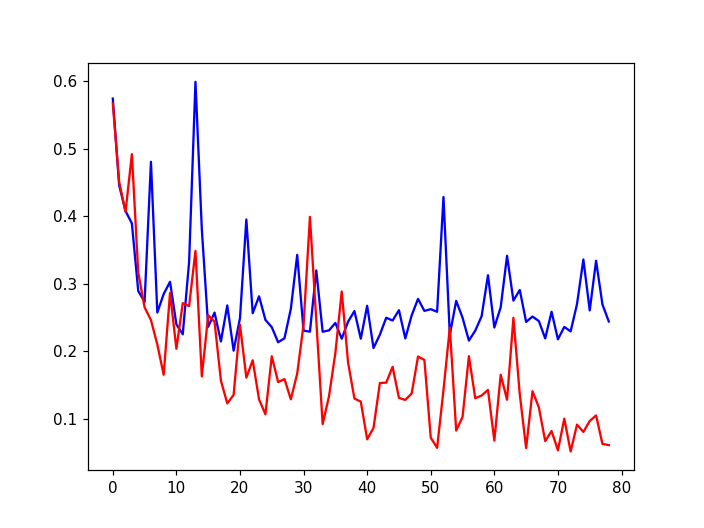

<IPython.core.display.Javascript object>


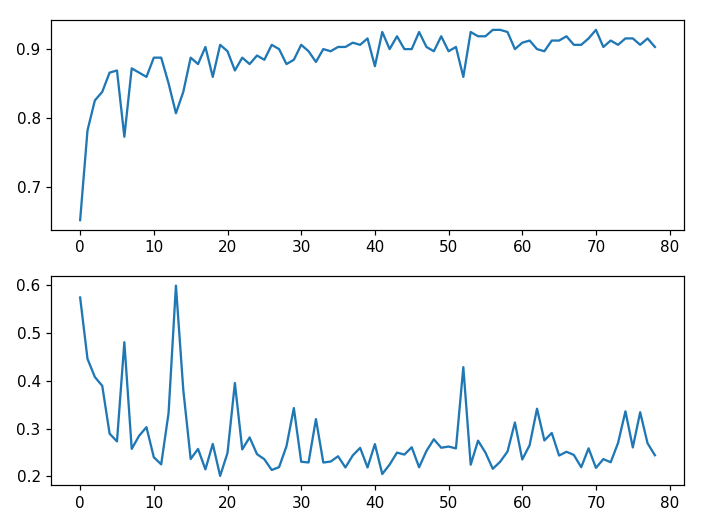

In [14]:
%matplotlib notebook
print('best Acc: {:.3}, Min loss: {:.3}'.format(best_accuracy,min_loss))
plt.plot(loss_rec[1:],'b')
plt.plot(loss_train[1:],'r')
plot_list([acc_rec[1:],loss_rec[1:]])

In [15]:
acc_rec_list = np.array(loss_rec)
acc_rec_list[acc_rec[:]==max(acc_rec)]

array([ 0.21774076], dtype=float32)

In [16]:
np.floor(1.8)

1.0

In [17]:
def predict_batch(test_imgages,inc_ang,length = 1000):
    prev_index = 0
    for x in range(int(np.floor(len(inc_ang)/length))):
        index = (x+1) * length
        feed_dict_sub = {input_: test_imgages[prev_index:index], input_post:inc_ang[prev_index:index], keep_prob:1,is_train:False} 
        
        
        pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
        if x == 0:
            return_sub = pred
        else:
            return_sub = np.concatenate((return_sub,pred))
        prev_index = index
    feed_dict_sub = {input_: test_imgages[prev_index:], input_post:inc_ang[prev_index:], keep_prob:1,is_train:False} 
    pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
    return_sub = np.concatenate((return_sub,pred))
    return return_sub

In [18]:
test_df, test_imgages = load_and_format('data/test.json')
print('ok')

ok


In [37]:
inc_ang = test_df['inc_angle'].replace('na',0) / 50
inc_ang = inc_ang.as_matrix().reshape([-1,1])

In [38]:
saver.restore(sess,"models/my_model_loss")
sub_loss = predict_batch(test_imgages,inc_ang)
saver.restore(sess,"models/my_model_acc")
sub_acc = predict_batch(test_imgages,inc_ang)


INFO:tensorflow:Restoring parameters from models/my_model_loss
INFO:tensorflow:Restoring parameters from models/my_model_acc


In [39]:
sub_loss = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_loss]
sub_acc = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_acc]
sub_data = (np.array(sub_loss) + np.array(sub_acc))/2

In [40]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['is_iceberg'] = sub_acc

In [41]:
sub.to_csv("sub/sub_loss{:.3}_acc{:.3}.csv".format(min_loss,best_accuracy), index = False)

In [34]:
saver.restore(sess,"models/my_model_loss")


INFO:tensorflow:Restoring parameters from models/my_model_loss


In [42]:
sub_acc

[0.00024563074111938477,
 0.2207263708114624,
 0.0,
 0.99965715,
 0.050281822681427002,
 0.00016140937805175781,
 0.087790727615356445,
 0.99978834,
 0.00086492300033569336,
 8.3446502685546875e-07,
 0.00015091896057128906,
 0.47316640615463257,
 0.0039395689964294434,
 0.56038743,
 0.0013152956962585449,
 0.019428730010986328,
 0.0036320686340332031,
 1.811981201171875e-05,
 0.010497331619262695,
 0.96663475,
 0.034907937049865723,
 0.4752388596534729,
 0.040135622024536133,
 0.24592185020446777,
 0.00071120262145996094,
 0.0026249885559082031,
 0.086591541767120361,
 0.0025464892387390137,
 0.068431675434112549,
 0.99973041,
 1.0728836059570312e-06,
 0.3732675313949585,
 0.046391069889068604,
 0.27767741680145264,
 0.8454408,
 0.85586977,
 0.65556198,
 0.5475927,
 0.21648132801055908,
 0.78481776,
 8.5711479187011719e-05,
 0.022187650203704834,
 0.081086695194244385,
 0.00022989511489868164,
 0.1275627613067627,
 0.92925161,
 0.99692851,
 4.4941902160644531e-05,
 1.0,
 0.107553660869